# Polynomial Regression

Estimated time needed: **40** minutes

What if your data is more complex than a straight line? Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called Polynomial Regression.

There are two factors when determining model performance: overfitting and underfitting. Overfitting is when the model is too complex and does well on the training data but not on the test data. Underfitting is when the model is too simple and performs poorly on the training and testing data sets.

Overfitting is simple to deal with, using methods like regularization, which we will discuss in the next lab. To deal with underfitting, we can build a more complex model using methods like polynomial regression. If making a more complex model does not work, this may involve using more data to train the model on or obtaining new features. As this process is complex, it's better to determine if the model can overfit the data first. Therefore, in this section, we will use Polynomial Regression to overfit the data to determine if we have an adequate amount of data.

In this notebook, we will explore Polynomial Regression and perform polynomial transform using individual features as well as multiple features.

## Objectives

After completing this lab you will be able to:

*   Understand the concept of  overfitting versus underfitting
*   Apply polynomial transforms to data
*   Perform  hyperparameters grid search on a model, using validation data


In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
from itertools import accumulate

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits, load_wine

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV





In [3]:
def get_r2_features(model, test=True):
    features = list(X)
    features.remove("three")
    
    R_2_train = []
    R_2_test = []
    
    for feature in features:
        model.fit(X_train[[feature]], y_train)
        
        R_2_test.append(model.score(X_test[[feature]]), y_test)
        R_2_train.append(model.score(X_train[[feature]]), y_train)
    
    plt.bar(features, R_2_train, label="Train")
    plt.bar(features, R_2_test, label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
    print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )
    
def plot_dis(y, yhat):
    
    plt.figure()
    ax1 = sns.displot(y, hist=False, color='r', label="Actual Value")
    sns.display(yhat, hist=False, color='b', label="Fitted Values", ax=ax1)
    plt.legend()
    
    plt.title('Actual vs Fitted values')
    plt.xlabel('Price in dollars')
    plt.ylabel('Proportion of cars')
    
    plt.show()
    plt.close()

In [9]:
import requests

def download(url, filename):
    res = requests.get(url)
    
    if res.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(res.content)

## **Reading and understanding our data**


In [10]:
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/encoded_car_data.csv'

download(URL, 'encoded_car_data.csv')

In [11]:
data = pd.read_csv('encoded_car_data.csv')
data.head()

,diesel,gas,std,turbo,convertible,hardtop,hatchback,sedan,wagon,4wd,...,wheelbase,curbweight,enginesize,boreratio,horsepower,carlength,carwidth,citympg,highwaympg,price
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,13495.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,16500.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,94.5,2823.0,152.0,2.68,154.0,171.2,65.5,19.0,26.0,16500.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,99.8,2337.0,109.0,3.19,102.0,176.6,66.2,24.0,30.0,13950.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,99.4,2824.0,136.0,3.19,115.0,176.6,66.4,18.0,22.0,17450.0


In [12]:
data.dtypes

diesel         float64
gas            float64
std            float64
turbo          float64
convertible    float64
hardtop        float64
hatchback      float64
sedan          float64
wagon          float64
4wd            float64
fwd            float64
rwd            float64
dohc           float64
dohcv          float64
l              float64
ohc            float64
ohcf           float64
ohcv           float64
rotor          float64
eight          float64
five           float64
four           float64
six            float64
three          float64
twelve         float64
two            float64
wheelbase      float64
curbweight     float64
enginesize     float64
boreratio      float64
horsepower     float64
carlength      float64
carwidth       float64
citympg        float64
highwaympg     float64
price          float64
dtype: object

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diesel       205 non-null    float64
 1   gas          205 non-null    float64
 2   std          205 non-null    float64
 3   turbo        205 non-null    float64
 4   convertible  205 non-null    float64
 5   hardtop      205 non-null    float64
 6   hatchback    205 non-null    float64
 7   sedan        205 non-null    float64
 8   wagon        205 non-null    float64
 9   4wd          205 non-null    float64
 10  fwd          205 non-null    float64
 11  rwd          205 non-null    float64
 12  dohc         205 non-null    float64
 13  dohcv        205 non-null    float64
 14  l            205 non-null    float64
 15  ohc          205 non-null    float64
 16  ohcf         205 non-null    float64
 17  ohcv         205 non-null    float64
 18  rotor        205 non-null    float64
 19  eight   

In [14]:
data.isna().sum()

diesel         0
gas            0
std            0
turbo          0
convertible    0
hardtop        0
hatchback      0
sedan          0
wagon          0
4wd            0
fwd            0
rwd            0
dohc           0
dohcv          0
l              0
ohc            0
ohcf           0
ohcv           0
rotor          0
eight          0
five           0
four           0
six            0
three          0
twelve         0
two            0
wheelbase      0
curbweight     0
enginesize     0
boreratio      0
horsepower     0
carlength      0
carwidth       0
citympg        0
highwaympg     0
price          0
dtype: int64

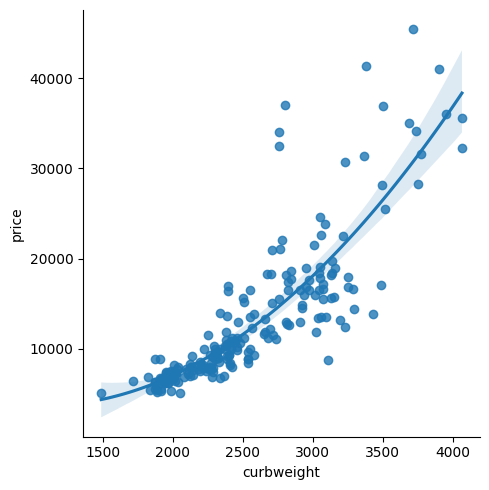

In [15]:
sns.lmplot(x="curbweight", y='price', data=data, order=2)

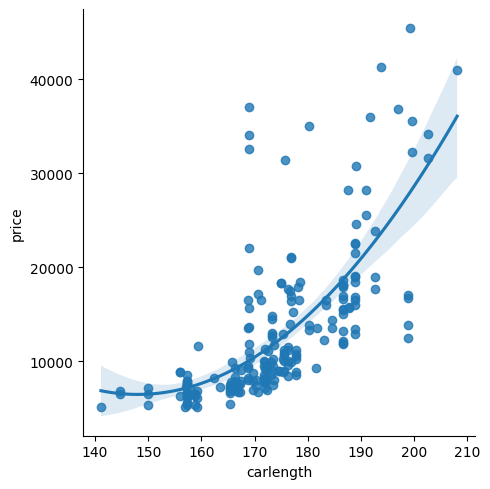

In [16]:
sns.lmplot(x="carlength", y='price', data=data, order=2)

## Exercise 1

In this Exercise, visualize the relationship between the 'horsepower' and the target variable, 'price'.


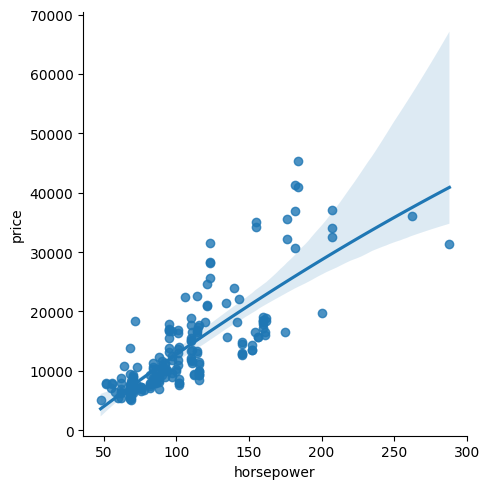

In [17]:
sns.lmplot(x='horsepower', y='price', data=data, order=2)

## Data Preparation

Let's first split our data into `X` features and `y` target.


In [18]:
x = data.drop('price', axis=1)
y = data['price']

## Train Test Split


In [19]:
random_seed = 42
train_split = 0.3

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=train_split, random_state=random_seed)

TypeError: got an unexpected keyword argument 'random_seed'